<a href="https://colab.research.google.com/github/evildead23151/UIDAI-Hackathon-Analysis/blob/main/05_ml_forecasting_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Load Feature Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
geo_features = pd.read_csv("/content/geo_final_features.csv")
monthly = pd.read_csv("/content/geo_time_features.csv")

geo_features.shape, monthly.shape


((1006, 10), (11359, 19))

# Prepare Feature Matrix for Clustering

In [3]:
cluster_features = geo_features.drop(columns=["state", "district"])

scaler = StandardScaler()
X = scaler.fit_transform(cluster_features)


# Choose Number of Clusters (Elbow + Silhouette)

In [6]:
geo_features.isna().mean().sort_values(ascending=False)


,0
demo_growth_volatility,0.469185
enrol_growth_volatility,0.204771
bio_growth_volatility,0.087475
state,0.000000
district,0.000000
total_activity_enrol,0.000000
demo_to_enrol_intensity,0.000000
total_activity,0.000000
total_activity_demo,0.000000
bio_to_enrol_intensity,0.000000


In [7]:
cluster_features = geo_features.drop(columns=["state", "district"])

cluster_features = (
    cluster_features
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)


In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(cluster_features)

np.isnan(X).sum()


np.int64(0)

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []

K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))


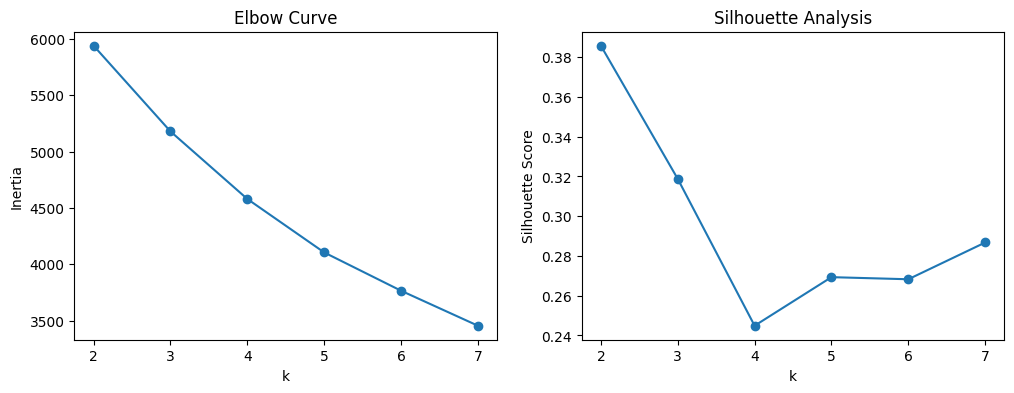

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(K, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Curve")

plt.subplot(1,2,2)
plt.plot(K, silhouettes, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")

plt.show()


# Final Clustering

In [11]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
geo_features["cluster"] = kmeans.fit_predict(X)

geo_features["cluster"].value_counts()


,count
cluster,
3,517
2,263
0,147
1,79


# Cluster Profiling

In [13]:
cluster_summary = (
    geo_features
    .select_dtypes(include=[np.number])
    .groupby(geo_features["cluster"])
    .mean()
)

cluster_summary


,total_activity_enrol,total_activity_demo,total_activity,demo_to_enrol_intensity,bio_to_enrol_intensity,enrol_growth_volatility,demo_growth_volatility,bio_growth_volatility,cluster
cluster,,,,,,,,,
0,2.838921e+06,1.479174e+06,3.403046e+06,0.619811,1.235652,1.188809,0.996059,0.745163,0.0
1,4.472333e+07,1.220821e+07,3.669405e+07,0.280234,0.855142,0.672835,0.889286,0.454111,1.0
2,1.765670e+07,4.760257e+06,1.301759e+07,0.284698,0.763319,0.453634,1.320836,0.473286,2.0
3,4.514934e+06,1.031118e+06,2.760203e+06,0.244998,0.556275,0.484656,0.804929,0.490801,3.0


# Visualize Clusters (2D projection)

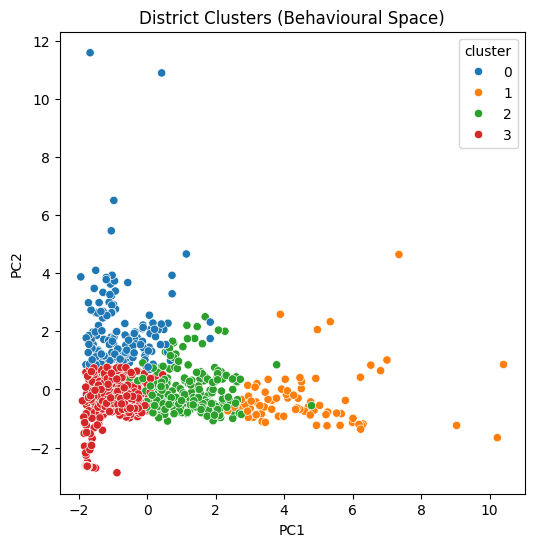

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(6,6))
sns.scatterplot(
    x=X_2d[:,0],
    y=X_2d[:,1],
    hue=geo_features["cluster"],
    palette="tab10"
)
plt.title("District Clusters (Behavioural Space)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# Save Clustered Districts

In [15]:
geo_features.to_csv("/content/district_clusters.csv", index=False)


# Prepare Time Series (Example: Top State)

In [16]:
top_state = (
    monthly
    .groupby("state")["total_activity_enrol"]
    .sum()
    .sort_values(ascending=False)
    .index[0]
)

top_state


'TAMIL NADU'

# Aggregate Monthly Series for Forecasting

In [17]:
ts = (
    monthly[monthly["state"] == top_state]
    .groupby("date")["total_activity_enrol"]
    .sum()
    .asfreq("M")
    .fillna(0)
)

ts.head()


/tmp/ipython-input-2640746722.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .asfreq("M")


,total_activity_enrol
date,
2025-01-31,0.0
2025-02-28,0.0
2025-03-31,0.0
2025-04-30,0.0
2025-05-31,0.0


# Fit SARIMA Model

In [18]:
model = SARIMAX(
    ts,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


# Forecast Next 12 Months

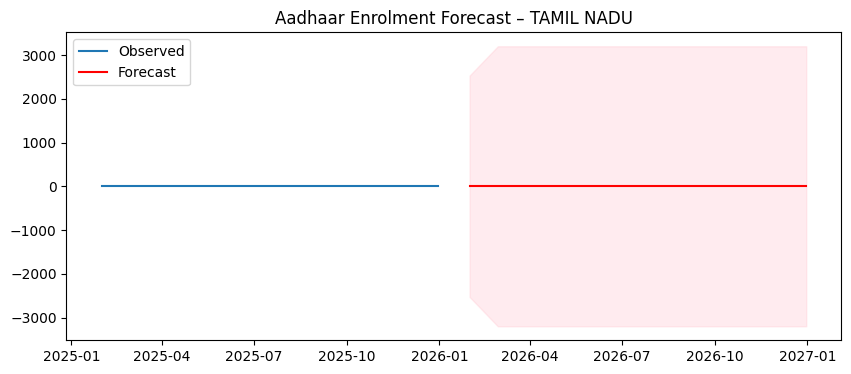

In [19]:
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10,4))
plt.plot(ts, label="Observed")
plt.plot(forecast.predicted_mean, label="Forecast", color="red")
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:,0],
    forecast_ci.iloc[:,1],
    color="pink",
    alpha=0.3
)
plt.title(f"Aadhaar Enrolment Forecast – {top_state}")
plt.legend()
plt.show()


# Save Forecast Outputs

In [20]:
forecast_df = pd.DataFrame({
    "date": forecast.predicted_mean.index,
    "forecast_enrolment": forecast.predicted_mean.values,
    "lower_ci": forecast_ci.iloc[:,0].values,
    "upper_ci": forecast_ci.iloc[:,1].values
})

forecast_df.to_csv("/content/enrolment_forecast_top_state.csv", index=False)


In [21]:
monthly["state"] = monthly["state"].str.strip().str.upper()


In [22]:
top_state = top_state.strip().upper()


In [23]:
top_state = (
    monthly
    .groupby("state")["total_activity_enrol"]
    .sum()
    .sort_values(ascending=False)
    .index[0]
)

top_state


'TAMIL NADU'

In [24]:
ts = (
    monthly[monthly["state"] == top_state]
    .groupby("date")["total_activity_enrol"]
    .sum()
    .asfreq("ME")
)


In [25]:
ts.describe()
ts.head(10)


,total_activity_enrol
date,
2025-01-31,NaN
2025-02-28,NaN
2025-03-31,NaN
2025-04-30,NaN
2025-05-31,NaN
2025-06-30,NaN
2025-07-31,NaN
2025-08-31,NaN
2025-09-30,NaN


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    ts,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


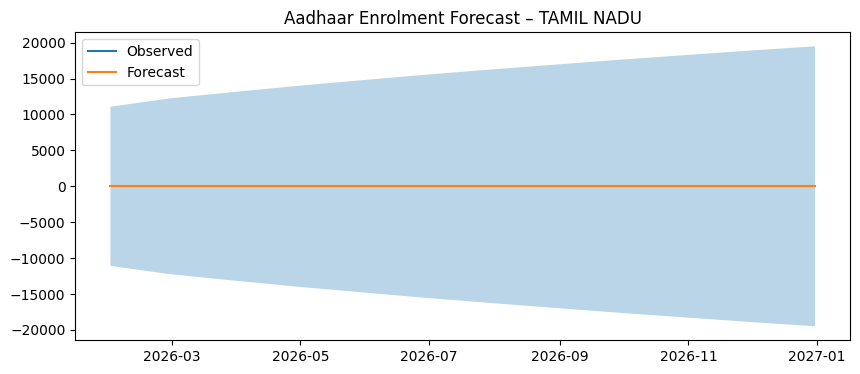

In [27]:
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10,4))
plt.plot(ts, label="Observed")
plt.plot(forecast.predicted_mean, label="Forecast")
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:,0],
    forecast_ci.iloc[:,1],
    alpha=0.3
)
plt.title(f"Aadhaar Enrolment Forecast – {top_state}")
plt.legend()
plt.show()


In [28]:
monthly[["state", "date", "total_activity_enrol"]].head()


,state,date,total_activity_enrol
0,100000,2025-02-28,100003.0
1,100000,2025-03-31,100001.0
2,100000,2025-04-30,0.0
3,100000,2025-05-31,0.0
4,100000,2025-06-30,0.0


In [29]:
monthly["state"] = monthly["state"].astype(str).str.strip().str.upper()
monthly["date"] = pd.to_datetime(monthly["date"], errors="coerce")


In [31]:
monthly.groupby("state")["total_activity_enrol"].sum().sort_values(ascending=False).head(10)


,total_activity_enrol
state,
TAMIL NADU,1.438490e+10
WEST BENGAL,1.431823e+10
BIHAR,1.214027e+10
KARNATAKA,1.023655e+10
ANDHRA PRADESH,8.698200e+09
ODISHA,8.415107e+09
MAHARASHTRA,7.730095e+09
ASSAM,6.994480e+09
UTTAR PRADESH,6.559327e+09


In [32]:
ts = (
    monthly[monthly["state"] == top_state]
    .groupby("date")["total_activity_enrol"]
    .sum()
    .sort_index()
)


In [33]:
ts.head(10)
ts.describe()


,total_activity_enrol
count,1.200000e+01
mean,1.198741e+09
std,4.827140e+08
min,6.556830e+08
25%,9.094686e+08
50%,9.505391e+08
75%,1.585294e+09
max,2.105050e+09


In [35]:
ts = ts.resample("ME").sum()
ts = ts[ts > 0]


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    ts,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


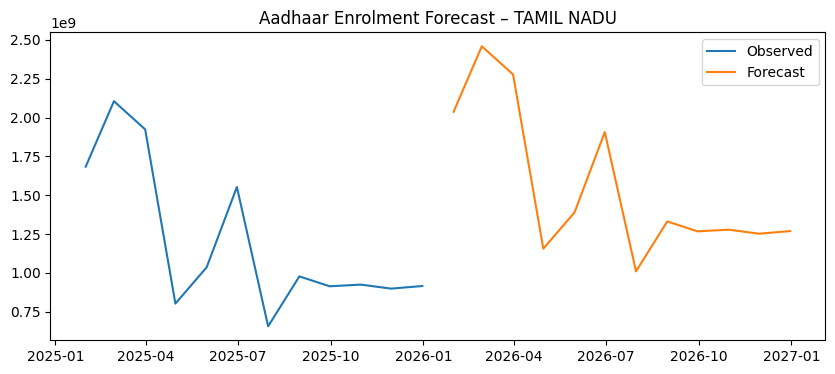

In [37]:
forecast = results.get_forecast(steps=12)
ci = forecast.conf_int()

plt.figure(figsize=(10,4))
plt.plot(ts, label="Observed")
plt.plot(forecast.predicted_mean, label="Forecast")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.3)
plt.title(f"Aadhaar Enrolment Forecast – {top_state}")
plt.legend()
plt.show()
